<a href="https://colab.research.google.com/github/tc3oliver/StratLabFreq/blob/dev/MACD_Divergence_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/StratLabFreq')
os.listdir()

['MACD_Divergence_Analysis.ipynb', 'data', 'TaipeiSansTCBeta-Regular.ttf']

In [17]:
import pandas as pd

In [18]:
dataframe = pd.read_json('./data/BTC_USDT-5m.json')
dataframe.columns=['date', 'open' , 'high', 'low', 'close', 'volume' ]
dataframe['date']=(pd.to_datetime(dataframe['date'],unit='ms'))
dataframe

,date,open,high,low,close,volume
0,2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061
1,2017-08-17 04:05:00,4261.48,4261.48,4261.48,4261.48,0.000000
2,2017-08-17 04:10:00,4261.48,4261.48,4261.48,4261.48,0.000000
3,2017-08-17 04:15:00,4261.48,4264.88,4261.48,4261.48,0.484666
4,2017-08-17 04:20:00,4264.88,4266.29,4264.88,4266.29,2.328570
...,...,...,...,...,...,...
617219,2023-07-06 05:50:00,30549.80,30569.99,30549.80,30563.11,105.865190
617220,2023-07-06 05:55:00,30563.11,30593.64,30563.11,30582.51,71.446400
617221,2023-07-06 06:00:00,30582.50,30599.30,30573.33,30575.48,88.509370
617222,2023-07-06 06:05:00,30575.48,30575.48,30560.00,30570.04,58.483620


In [19]:
!pip install mplfinance

In [20]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.font_manager as fm
import matplotlib as mpl

# 下載字體
# !wget https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download -O TaipeiSansTCBeta-Regular.ttf

# 註冊字體
# font_path = 'TaipeiSansTCBeta-Regular.ttf'
# prop = fm.FontProperties(fname=font_path)
# 設定 matplotlib 字體
# mpl.rcParams['font.family'] = prop.get_name()
# font={'font.family': prop.get_name()}
# style=mpf.make_mpf_style(base_mpf_style='default', rc=font)

In [21]:
import random

count = 40

def get_random_count_values_dataframe(df):
    if len(df) < count:
        raise ValueError("DataFrame 中的資料數量不足 40 個")

    start_index = random.randint(0, len(df) - count)

    selected_values = df.iloc[start_index : start_index + count]

    selected_df = pd.DataFrame(selected_values)

    return selected_df

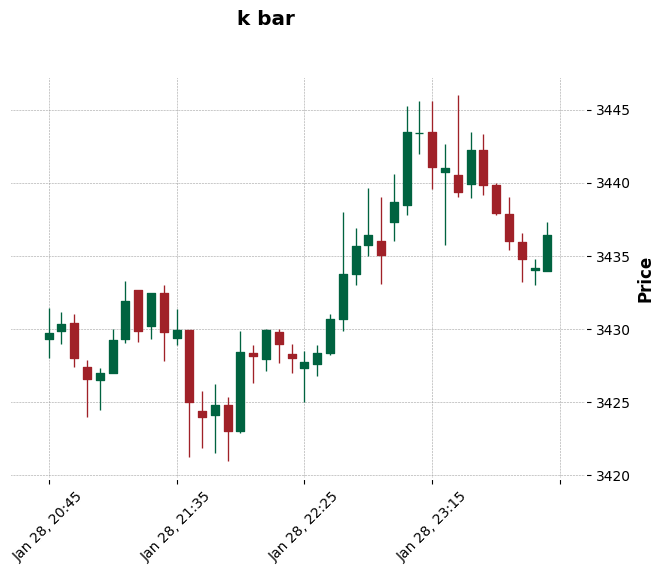

In [22]:
df = get_random_count_values_dataframe(dataframe)

# 將索引設定為 DatetimeIndex
df.set_index('date', inplace=True)

# 繪製 K 線圖
mpf.plot(df, type='candle', style='charles', title='k bar')

# 顯示圖表
plt.show()

In [23]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4267    0  4267    0     0   7284      0 --:--:-- --:--:-- --:--:--  7281
100  517k  100  517k    0     0   354k      0  0:00:01  0:00:01 --:--:-- 4110k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4291    0  4291    0     0   7550      0 --:--:-- --:--:-- --:--:--  7554
100  392k  100  392k    0     0   265k      0  0:00:01  0:00:01 --:--:--  579k


In [24]:
import talib.abstract as ta

In [25]:
macd = ta.MACD(dataframe, fastperiod=13, slowperiod=34)
dataframe['macdhist'] = macd['macdhist']

In [26]:
# new
import statistics

# 尋找三個峰值且這些波峰連續升高
def find_peak_sequence(data):
    peaks_index = []
    wave = []

    for i in range(len(data)):
        if i == len(data) - 1:
            break
        d = abs(data[i])
        if len(wave) == 0 or d > wave[-1]:
            wave.append(d)
        else:
            if len(wave) > 1:
                peaks_index.append(i-1)
            wave = [d]

    if len(wave) > 0:
        peaks_index.append(i)

    highlighted_points = [(index, data[index]) for index in peaks_index]

    temp = highlighted_points[-1]

    # new
    if abs(statistics.mean(x[1] for x in highlighted_points[-5:-1])) > abs(temp[-1]):
      return False, []

    highlighted_points = highlighted_points[:-1]

    # new
    highlighted_points = [n for n in highlighted_points if n[1] < 0]

    highlighted_points = sorted(
        highlighted_points, key=lambda x: abs(x[1]), reverse=True)[:2]
    highlighted_points = sorted(
        highlighted_points, key=lambda x: x[0], reverse=False)
    highlighted_points.append(temp)

    if len(highlighted_points) >= 3:
        if abs(highlighted_points[-3][1]) > abs(highlighted_points[-2][1]) > abs(highlighted_points[-1][1]):
                return True, highlighted_points

    return False, []

# 多單條件檢查 零軸以下的 MACD 柱狀體應該大於 windows 的一半
def find_peak_sequence_logn_wrapper(data):
  if data[-1] > 0:
    return False, []
  count = sum(1 for value in data if value < 0)
  if count < (len(data) / 2):
      return False, []
  return find_peak_sequence(data)

In [27]:
import numpy as np

# dataframe['is_low_decreasing'] = dataframe['high'].rolling(window=count).apply(lambda x: x[-1] < max(x[:-1]), raw=True)
# dataframe['is_low_decreasing'] = dataframe['high'].rolling(window=count).apply(lambda x: x[-1] < x[0], raw=True)
dataframe['is_low_decreasing'] = dataframe['high'].rolling(window=count).apply(lambda x: (x[-1] < x[0]) & (x[-1] < max(x[:-1])), raw=True)


[7.302415847011233, -2.94366147034701, -13.121019576753852, -20.74792678513724, -28.640554106776477, -35.196426096812075, -39.23680744662673, -52.51738212200437, -56.54532556673165, -51.82199433776621, -54.14278530256414, -51.973336025552115, -38.71152982338378, -25.229372271615915, -21.31630994590457, -17.396904132083925, -6.014338701051468, 4.9888389712335695, 12.960451292623015, 13.365109052240946, 13.922767295281806, 9.66231912600761, 2.5254135955065466, -2.747586019154519, -2.7747377675428035, -5.449796183863169, -13.794662172206754, -16.50815725715879, -17.399330464826814, -17.970983579302466, -10.529736447030608, -9.958752273092177, -22.30412310978101, -24.753158865798916, -23.407369586555063, -33.55648826099029, -42.63769885027408, -34.88256235094721, -29.592193597403664, -22.53738561848283]
[(8, -56.54532556673165), (10, -54.14278530256414), (39, -22.53738561848283)]


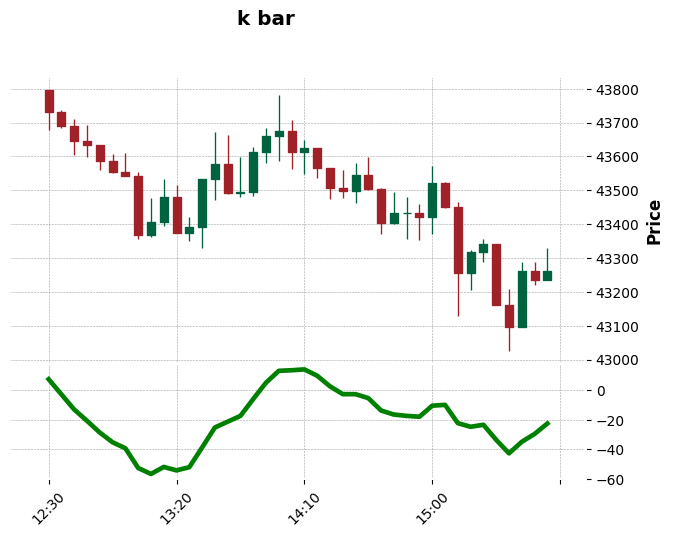

In [28]:
import numpy as np

while True:
  df = get_random_count_values_dataframe(dataframe)
  data = df['macdhist'].values.tolist()

  isfind, l = find_peak_sequence_logn_wrapper(data)


  if isfind:
    print(data)
    print(l)
    if df['is_low_decreasing'].values.tolist()[-1]:
      df.set_index('date', inplace=True)

      # 建立一個 MACD histogram 的圖像
      ap = mpf.make_addplot(df['macdhist'], panel=1, color='g', secondary_y=False)

      # 繪製 K 線圖，並添加 MACD histogram
      mpf.plot(df, type='candle', style='charles', title='k bar', addplot=ap)

      # 顯示圖表
      plt.show()

      break

In [29]:
df = get_random_count_values_dataframe(dataframe)
df.head()

,date,open,high,low,close,volume,macdhist,is_low_decreasing
246182,2019-12-24 07:15:00,7322.60,7324.56,7318.00,7318.03,90.094058,-2.111126,0.0
246183,2019-12-24 07:20:00,7318.40,7321.06,7301.14,7307.83,176.308420,-3.050674,0.0
246184,2019-12-24 07:25:00,7307.30,7307.83,7293.52,7294.38,269.729402,-4.459271,1.0
246185,2019-12-24 07:30:00,7295.35,7298.10,7266.01,7289.06,492.964433,-5.543111,1.0
246186,2019-12-24 07:35:00,7287.20,7301.64,7277.03,7292.18,213.793850,-5.780533,1.0


In [30]:
import numpy as np


dataframe['is_low_decreasing'] = dataframe['high'].rolling(window=count).apply(lambda x: (x[-1] < x[0]) & (x[-1] < max(x[:-1])), raw=True)


# Filter the DataFrame where 'is_low_decreasing' is True
filtered_df = dataframe[dataframe['is_low_decreasing'] == True]

# Print the filtered DataFrame
print(filtered_df)

                      date      open      high       low     close     volume  \
45     2017-08-17 07:45:00   4287.41   4287.41   4287.41   4287.41   0.004263   
105    2017-08-17 12:45:00   4430.00   4430.00   4411.00   4411.00   0.699498   
106    2017-08-17 12:50:00   4420.00   4431.13   4411.00   4411.00   0.147476   
107    2017-08-17 12:55:00   4411.00   4411.00   4411.00   4411.00   0.000000   
108    2017-08-17 13:00:00   4411.00   4430.00   4411.00   4430.00   0.610006   
...                    ...       ...       ...       ...       ...        ...   
617211 2023-07-06 05:10:00  30462.37  30462.37  30438.26  30438.27  83.211070   
617212 2023-07-06 05:15:00  30438.26  30460.80  30438.26  30458.45  51.660800   
617213 2023-07-06 05:20:00  30458.44  30464.11  30458.44  30464.11  24.107720   
617214 2023-07-06 05:25:00  30464.10  30480.69  30464.10  30480.69  40.571040   
617215 2023-07-06 05:30:00  30480.69  30499.99  30480.68  30499.99  34.391400   

        macdhist  is_low_de